## Lab 3: 

* Jacob Stokes - jts3867
* Andrew Annestrand - ata758 
* Musa Rafik - mar6827

## Preprocessing

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr

from sklearn.model_selection import KFold
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)


%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

In [2]:
train = pd.read_csv("../input/train.csv")
test = pd.read_csv("../input/test.csv")

In [3]:
train.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml     140000  
4   2008        WD         Normal     250000  

[5 rows x 81 columns]

In [4]:
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))

###Data preprocessing: 
We're not going to do anything fancy here: 
 
- First I'll transform the skewed numeric features by taking log(feature + 1) - this will make the features more normal    
- Create Dummy variables for the categorical features    
- Replace the numeric missing values (NaN's) with the mean of their respective columns

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbd9edaf160>,
      dtype=object)

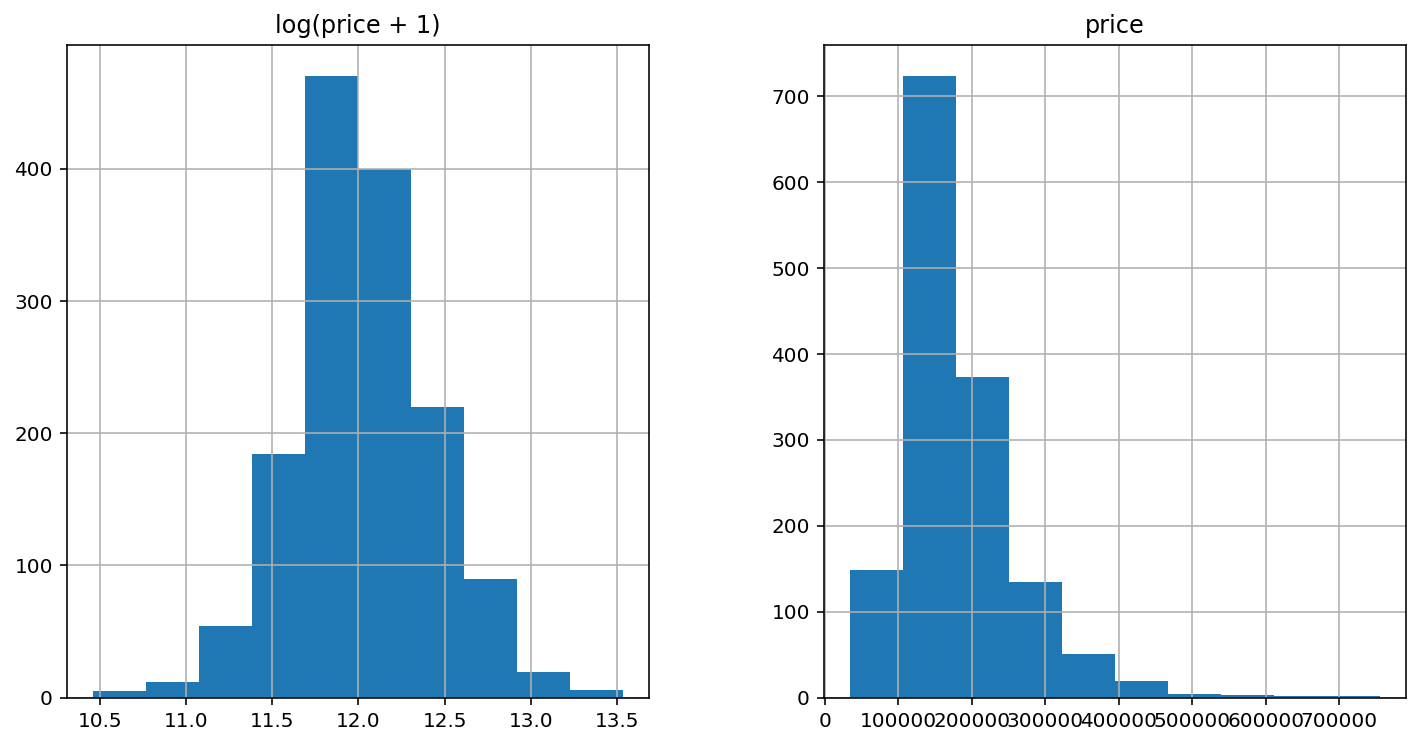

In [5]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame({"price":train["SalePrice"], "log(price + 1)":np.log1p(train["SalePrice"])})
prices.hist()

In [6]:
#log transform the target:
train["SalePrice"] = np.log1p(train["SalePrice"])

#log transform skewed numeric features:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

In [7]:
all_data = pd.get_dummies(all_data)

In [8]:
#filling NA's with the mean of the column:
all_data = all_data.fillna(all_data.mean())

In [9]:
#creating matrices for sklearn:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice

In [10]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, Lasso, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, np.array(X_train), np.array(y), scoring="neg_mean_squared_error", cv = kfolds))
    return(rmse)

## Problem 2: Simple Ridge Regression

Here we run a ridge regression with alpha set to 0.1. 

In [11]:
ridge_model = Ridge(alpha=0.1)
ridge_model.fit(X_train, y)
print(rmse_cv(ridge_model))


predictions = np.expm1(ridge_model.predict(X_test))

[0.1088122  0.14368417 0.12308564 0.12385737 0.15028028 0.20652642
 0.14414075 0.11264046 0.13031523 0.08629446]


In [12]:
turn_in = pd.DataFrame(test['Id'])
turn_in['SalePrice'] = predictions

turn_in.to_csv('FirstSubmission.csv',index=False)
# We got a RMSE of 0.13029

## Problem 3: Comparing Ridge and Lasso
In this problem we run a CV ridge and lasso model and compare the best scores we can get from each model. From the results we see that Ridge performs better than Lasso generally for this data set.

In [13]:
# Problem 3

ridgecv_model = RidgeCV()
lassocv_model = LassoCV()

ridgecv_model.fit(X_train, y)
lassocv_model.fit(X_train, y)

print(rmse_cv(ridgecv_model))
print(rmse_cv(lassocv_model))

[0.10765397 0.14410231 0.11323435 0.12893532 0.14272373 0.18212833
 0.12869769 0.10978299 0.12955362 0.08610172]
[0.18814293 0.21021651 0.17392941 0.17781418 0.17887062 0.20438118
 0.20848141 0.17581564 0.18470512 0.15196888]


In [14]:
# Best score for Ridge: .1104
# Best score for Lasso: .1736

## Problem 4
For this problem we are training many lasso models and graphing the effect of the magnitude of alphas on coefficients. In our graph, the number of non-zero coefficients is shown to increase as the value of alpha decreases.

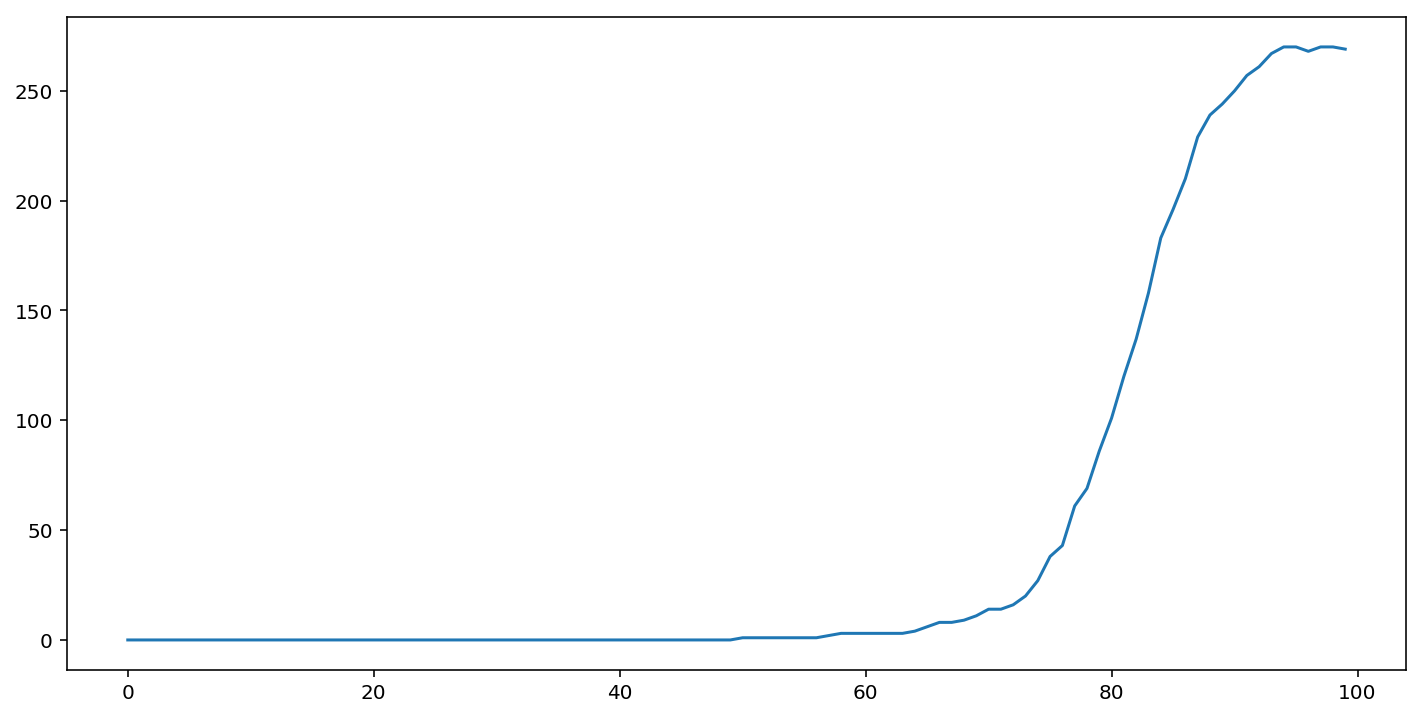

In [15]:
# Problem 4

alphas = 10**np.linspace(10,-6,100)*.5
non_zero_coefs = []

for a in alphas:
    lasso_model = Lasso(alpha=a,max_iter=100000)
    lasso_model.fit(X_train, y)
    
    num_non_zero = 0
    for coef in lasso_model.coef_:
        if (abs(coef) !=0):
            num_non_zero += 1
    non_zero_coefs.append(num_non_zero)
    
    
sns.lineplot(list(range(0,100)),non_zero_coefs)
# Shown below, we are plotting the number of non-zero coefficients as our alpha size decreases. This graph validates our intuition
# that as our regularization weight increases, more coefficients will zero out.

## Problem 5 
For this problem, we train both a lassocv and ridgecv and use their predictions on test data as features for another ridgecv model. This is the essence of "stacking." We stack the results of the models we train so that we can get the best from each and reduce our bias.

In [16]:
# Problem 5
# Add the outputs of models as features and train a ridge regression on all features plus model outputs
stacking_data_train = X_train.copy(deep=True)
stacking_data_train['ridge_predictions'] = pd.Series(ridgecv_model.predict(X_train))
stacking_data_train['lasso_predictions'] = pd.Series(lassocv_model.predict(X_train))

stacking_data_test = X_test.copy(deep=True)
stacking_data_test['ridge_predictions'] = pd.Series(ridgecv_model.predict(X_test))
stacking_data_test['lasso_predictions'] = pd.Series(lassocv_model.predict(X_test))


stacked_ridge_model = RidgeCV()
stacked_ridge_model.fit(stacking_data_train, y)

predictions = np.expm1(stacked_ridge_model.predict(stacking_data_test))
turn_in = pd.DataFrame(test['Id'])
turn_in['SalePrice'] = predictions

turn_in.to_csv('StackedRidgeSubmission.csv',index=False)


In [17]:
# The above model returned a RMSE of 0.12241 which is an improvement over the previous one!

## Problem 6 
For the first part of this problem we just run a default XGBoost and get a score. It's not too great so we find some optimal hyperparametes per other notebooks and train another XGBoost.

In [18]:
# Problem 6
from xgboost import XGBRegressor

my_model = XGBRegressor(silent=True)
my_model.fit(X_train, y, verbose=False)
print(rmse_cv(my_model))

predictions = np.expm1(my_model.predict(X_test))
turn_in = pd.DataFrame(test['Id'])
turn_in['SalePrice'] = predictions

turn_in.to_csv('XGBoost_no_tuning.csv',index=False)

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[0.13043751 0.15175771 0.10319462 0.13488255 0.15912402 0.13230677
 0.14952718 0.11621785 0.13778941 0.09205627]


In [19]:
xgb_model = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=.4603, gamma=.0468, learning_rate=0.05, max_delta_step=0,
       max_depth=3, min_child_weight=1.7817, missing=None, n_estimators=2200,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0.4640, reg_lambda=0.8571, scale_pos_weight=1, seed=42,
       silent=True, subsample=0.5213)
print(rmse_cv(xgb_model))

xgb_model.fit(X_train, y)
predictions = np.expm1(xgb_model.predict(X_test))
turn_in = pd.DataFrame(test['Id'])
turn_in['SalePrice'] = predictions

turn_in.to_csv('XGBoost_with_tuning.csv',index=False)

[0.10940141 0.14424263 0.09646917 0.12177479 0.14218592 0.14066332
 0.13124592 0.11642555 0.12350134 0.08003638]


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


* XGBoost MSE no tuning: 0.13904
* XGBoost MSE with tuning: 0.13136

## Problem 7
For this part we are going to try and get the best score we can. First we are going to try and blend 3 different MLR models and see what we get. After that, we will attempt to stack and then blend many models to improve accuracy and prevent overfitting.

In [26]:
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import ElasticNetCV

alphas_ridge = list(np.linspace(14.5,15.6,11))
alphas_lasso = [5e-05,.0001,.0002,.0003,.0004,.0005,.0006,.0007,.0008]
alphas_e = [.0001,.0002,.0003,.0004,.0005,.0006,.0007]
l1ratio_e = [.8,.85,.9,.95,.99,1]

ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=alphas_ridge, cv=kfolds))
lasso = make_pipeline(RobustScaler(), LassoCV(alphas=alphas_lasso, max_iter=1e7, cv=kfolds, random_state=42))
elasticnet = make_pipeline(RobustScaler(), ElasticNetCV(max_iter=1e7, alphas=alphas_e, cv=kfolds, l1_ratio=l1ratio_e))

models = {'Ridge': ridge,
          'Lasso': lasso,
          'ElasticNet': elasticnet}

predictions = {}
scores = {}

for name, model in models.items():
    model.fit(X_train, y)
    predictions[name] = model.predict(X_train)
    
#     score = rmse_cv(model)
#     scores[name] = (score.mean(), score.std())
    
print(scores)    

{}


In [27]:
from sklearn.metrics import mean_squared_error

blended_predictions = (predictions['ElasticNet'] + predictions['Lasso'] + predictions['Ridge'])/3
print(np.sqrt(mean_squared_error(y, blended_predictions)))


0.10326322904435709


In [28]:
test_predictions = {}

for name, model in models.items():
    model.fit(X_train, y)
    test_predictions[name] = np.expm1(model.predict(X_test))

final_predictions = (test_predictions['ElasticNet'] + test_predictions['Lasso'] + test_predictions['Ridge'])/3
turn_in = pd.DataFrame(test['Id'])
turn_in['SalePrice'] = final_predictions

turn_in.to_csv('BlendingMLRModels.csv',index=False)

In [29]:
# Ok so now we have tried blending and stacking. Let's see if we can put it all together and climb the leaderboards.

from mlxtend.regressor import StackingCVRegressor

stacking_model = StackingCVRegressor(regressors=(ridge, lasso, elasticnet, xgb_model), meta_regressor=ridge, use_features_in_secondary=True)
stacking_model.fit(X_train, y)

StackingCVRegressor(cv=5,
                    meta_regressor=XGBRegressor(base_score=0.5,
                                                booster='gbtree',
                                                colsample_bylevel=1,
                                                colsample_bynode=1,
                                                colsample_bytree=0.4603,
                                                gamma=0.0468,
                                                importance_type='gain',
                                                learning_rate=0.05,
                                                max_delta_step=0, max_depth=3,
                                                min_child_weight=1.7817,
                                                missing=None, n_estimators=2200,
                                                n_jobs=1, nthread=None,
                                                objective='reg:linear',
                                                random_

In [31]:
# Stacking has worked, now we should get our blended results
blended_stacked_results = (np.expm1(xgb_model.predict(X_test)) + np.expm1(stacking_model.predict(np.array(X_test))) + np.expm1(lasso.predict(X_test)) + np.expm1(ridge.predict(X_test)) + np.expm1(elasticnet.predict(X_test)))/5
print(blended_stacked_results)

turn_in = pd.DataFrame(test['Id'])
turn_in['SalePrice'] = blended_stacked_results
turn_in.to_csv('StackedBlended.csv',index=False)

[120247.4986126  155354.47027494 180965.91241369 ... 168370.46769335
 118019.7948116  222502.40273571]


Our final and best MSE from a stacked and blended model was 0.1898 which puts us in the top 18% of competitors. I believe that in order to achieve a better MSE, we would need to do a bit more work in preprocessing our data. We kind of overlooked this part but could tell its importance by looking at other popular notebooks. Other things we learned is that ensembling is an effective strategy that should be used in regression.